In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torchvision import transforms

In [3]:
device = 'mps'
device

'mps'

In [4]:
train_dir = '/Users/hiteshgupta/Documents/ML-CV/Vision Transformer/dataset/train'
val_dir = '/Users/hiteshgupta/Documents/ML-CV/Vision Transformer/dataset/val'

# Create Datasets and DataLoaders

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
def create_dataloaders(train_dir: str, val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int):
    # Use image folder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform = transform)
    val_data = datasets.ImageFolder(val_dir, transform = transform)

    # Get Class Names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True, 
        num_workers = num_workers,
        pin_memory = True,
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size = batch_size,
        shuffle = True, 
        num_workers = num_workers,
        pin_memory = True,
    )

    return train_dataloader, val_dataloader, class_names

In [7]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f'Manully Created transforms: {manual_transforms}')

Manully Created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, val_dataloader, class_names = create_dataloaders(
    train_dir,
    val_dir,
    manual_transforms,
    BATCH_SIZE,
    num_workers = 8
)

print(f'Class Names: {class_names}')
print(f'Length of Train Dataloader: {len(train_dataloader)}')
print(f'Length of Val Dataloader: {len(val_dataloader)}')

Class Names: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily']
Length of Train Dataloader: 427
Length of Val Dataloader: 4


torch.Size([3, 224, 224]) tensor(10)


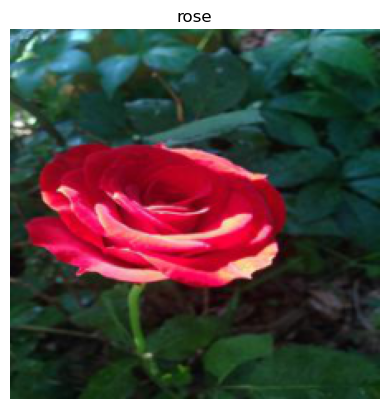

In [10]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [11]:
class PatchEmbedding(nn.Module):
    """Turn a 2D input image into a 1D sequence learnable embedding vectors.
    
    Args:
        in_channels (int): Number of input channels
        patch_size (int): The size of the square patch to be created
        emb_size (int): The embedding size of each patch
    """
    # Initialize the class
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768): # 16*16*3 = 768
        super().__init__()
        
        # Break image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=emb_size, kernel_size=patch_size, stride=patch_size, padding=0)

        # Create a layer to flatten the image into a sequence
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # Forward pass
    def forward(self, x):
        # Create assetion to check the input image size
        image_res = x.shape[-1]
        assert image_res % patch_size == 0, f"Image resolution {image_res} must be divisible by {patch_size}"
        
        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)

In [12]:
def set_seeds(seed : int = 42):
    torch.manual_seed(seed)
    torch.mps.manual_seed(0)
    
set_seeds()
patch_size = 16
# Create an instance of the PatchEmbedding class
patchify = PatchEmbedding(in_channels=3, patch_size=patch_size, emb_size=768)

In [13]:
    print(f"Imput Image Shape : {image.unsqueeze(0).shape}")
    patched_embedded_image = patchify(image.unsqueeze(0))
    print(f"Output Shape: {patched_embedded_image.shape}")

Imput Image Shape : torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 196, 768])


In [14]:
print(f'Image Tensor Shape : {image.shape}')
height, width = image.shape[1], image.shape[2]

Image Tensor Shape : torch.Size([3, 224, 224])


In [15]:
#Get image tensor and add batch dimensions
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape:{x.shape}")

Input image with batch dimension shape:torch.Size([1, 3, 224, 224])


In [16]:
# Pass image through patch embedding layer
patch_embedding = patchify(x)
print(f"Patching embedding shape : {patch_embedding.shape}")

Patching embedding shape : torch.Size([1, 196, 768])


In [17]:
# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape : {class_token.shape}")

Class token embedding shape : torch.Size([1, 1, 768])


In [18]:
# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim =1)
print(f"Patch embedding with class token shape : {patch_embedding_class_token.shape}")

Patch embedding with class token shape : torch.Size([1, 197, 768])


In [19]:
# Create position embedding
number_of_patches = int((height*width)/patch_size**2) 
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

In [20]:
# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and embedding shape : {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)

Patch and embedding shape : torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4030,  0.2288, -0.2686,  ...,  0.4684, -0.2251, -0.0436],
         [-0.4567,  0.1083, -0.1126,  ...,  0.3493, -0.1511,  0.0683],
         ...,
         [-0.1409,  0.0807, -0.1155,  ...,  0.1708, -0.0883,  0.0668],
         [-0.1607,  0.0877, -0.0986,  ...,  0.1581, -0.0720,  0.0538],
         [-0.1279,  0.0625, -0.0894,  ...,  0.1835, -0.0844,  0.0504]]],
       grad_fn=<CatBackward0>)


# Creating Vision Transformer

## MultiHead self Attention

In [21]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embedding_dim:int = 768, num_heads:int = 12, attn_dropout:float = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query =x, key = x, value = x, need_weights = False)
        return attn_output

# MLP Block

In [22]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim:int = 768, mlp_size: int=3072, dropout : float = 0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, 
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dim), 
            nn.Dropout(p = dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

## Creating a Transformer encoder by combining our custom made layers

In [23]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int= 12, mlp_size: int = 3072, mlp_dropout: float = 0.1, attn_dropout: float = 0):
        super().__init__()
        # Create MSA Block
        self.msa_block = MultiheadSelfAttention(embedding_dim = embedding_dim, num_heads=num_heads, attn_dropout = attn_dropout)

        # Create MLP block
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [24]:
!pip install torchinfo

In [25]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model = transformer_encoder_block, col_name = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20, row_settings = ["var_names"])

Layer (type (var_name))                                      Param #
TransformerEncoderBlock (TransformerEncoderBlock)            --
├─MultiheadSelfAttention (msa_block)                         --
│    └─LayerNorm (layer_norm)                                1,536
│    └─MultiheadAttention (multihead_attn)                   1,771,776
│    │    └─NonDynamicallyQuantizableLinear (out_proj)       590,592
├─MLPBlock (mlp_block)                                       --
│    └─LayerNorm (layer_norm)                                1,536
│    └─Sequential (mlp)                                      --
│    │    └─Linear (0)                                       2,362,368
│    │    └─GELU (1)                                         --
│    │    └─Dropout (2)                                      --
│    │    └─Linear (3)                                       2,360,064
│    │    └─Dropout (4)                                      --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable p

# Lets Build the VISION TRANSFORMER

In [26]:
class ViT(nn.Module):
    def __init__(self, img_size: int = 224, 
                 in_channels: int = 3, 
                 patch_size: int = 16,
                 num_transformers_layers: int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072, 
                 num_heads: int = 12,
                 attn_dropout: float = 0,
                 mlp_dropout : float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size:{img_size}, patch size = {patch_size}"
    
        self.num_patches = (img_size * img_size) // (patch_size **2)
    
        self.class_embedding = nn.Parameter(data = torch.randn(1,1,embedding_dim), requires_grad=True)
    
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad = True)
    
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)
    
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,patch_size=patch_size, emb_size=embedding_dim)
    
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim, 
                                                                           num_heads=num_heads, 
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformers_layers)])
    
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim = 1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:,0])

        return x

# Training the model

In [27]:
vit = ViT(num_classes=len(class_names))

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7437 | train_acc: 0.0720 | test_loss: 2.6419 | test_acc: 0.0547
